## Problem Statement

Congratulations – you have been hired as Chief Data Scientist of MedCamp – a not for profit organization dedicated in making health conditions for **working professionals better**. MedCamp was started because the founders saw their family suffer due to bad work life balance and neglected health.

MedCamp organizes health camps in several cities with low work life balance. They reach out to working people and ask them to register for these health camps. For those who attend, MedCamp provides them facility to undergo health checks or increase awareness by visiting various stalls (depending on the format of camp). 

MedCamp has conducted 65 such events over a period of 4 years and they see a **high drop off between “Registration” and Number of people taking tests at the Camps.** In last 4 years, they have stored data of ~110,000 registrations they have done.

One of the huge costs in arranging these camps is the amount of inventory you need to carry. If you carry more than required inventory, you incur unnecessarily high costs. On the other hand, if you carry less than required inventory for conducting these medical checks, people end up having bad experience.



## The Process:

MedCamp employees / volunteers reach out to people and drive registrations.

During the camp, People who “ShowUp” either undergo the medical tests or visit stalls depending on the format of health camp.



### Other things to note:

Since this is a completely voluntary activity for the working professionals, MedCamp usually has little profile information about these people.

For a few camps, there was hardware failure, so some information about date and time of registration is lost.

MedCamp runs 3 formats of these camps. **The first and second format provides people with an instantaneous health score.** The third format provides information about several health issues through various awareness stalls.



### Favorable outcome:

For the first 2 formats, a favourable outcome is defined as getting a health_score, while in the third format it is defined as visiting at least a stall.

You need to predict the chances (probability) of having a favourable outcome.

## Target creation

In [2]:
# Importing Necessray libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns',100)
import scipy.stats as stats
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [3]:
# read file
train = pd.read_csv(r"C:\Users\HP\Downloads\Train_2\Train\Train.csv")
test = pd.read_csv(r"C:\Users\HP\Downloads\test_l0Auv8Q.csv")
submission = pd.read_csv(r"C:\Users\HP\Downloads\sample_submmission.csv")

In [4]:
# additional files of dataset

fhc = pd.read_csv(r"C:\Users\HP\Downloads\Train_2\Train\First_Health_Camp_Attended.csv")
hc = pd.read_csv(r"C:\Users\HP\Downloads\Train_2\Train\Health_Camp_Detail.csv")
pp = pd.read_csv(r"C:\Users\HP\Downloads\Train_2\Train\Patient_Profile.csv")
shc = pd.read_csv(r"C:\Users\HP\Downloads\Train_2\Train\Second_Health_Camp_Attended.csv")
thc = pd.read_csv(r"C:\Users\HP\Downloads\Train_2\Train\Third_Health_Camp_Attended.csv")

In [5]:
## Name of variables

print(fhc.columns)
print(shc.columns)
print(thc.columns)
print(pp.columns)
print(hc.columns)

Index(['Patient_ID', 'Health_Camp_ID', 'Donation', 'Health_Score',
       'Unnamed: 4'],
      dtype='object')
Index(['Patient_ID', 'Health_Camp_ID', 'Health Score'], dtype='object')
Index(['Patient_ID', 'Health_Camp_ID', 'Number_of_stall_visited',
       'Last_Stall_Visited_Number'],
      dtype='object')
Index(['Patient_ID', 'Online_Follower', 'LinkedIn_Shared', 'Twitter_Shared',
       'Facebook_Shared', 'Income', 'Education_Score', 'Age',
       'First_Interaction', 'City_Type', 'Employer_Category'],
      dtype='object')
Index(['Health_Camp_ID', 'Camp_Start_Date', 'Camp_End_Date', 'Category1',
       'Category2', 'Category3'],
      dtype='object')


In [6]:
## lets combine the data

combined = pd.concat([train,test],ignore_index=True)

In [7]:
combined.shape,train.shape,test.shape

((110527, 8), (75278, 8), (35249, 8))

In [8]:
## lets joined patient profile to the combined dataset

combined = pd.merge(combined,pp, on =['Patient_ID'],how='left')
combined = pd.merge(combined, fhc , on=['Patient_ID','Health_Camp_ID'],how='left')
combined = pd.merge(combined, shc , on=['Patient_ID','Health_Camp_ID'],how='left')
combined = pd.merge(combined, thc , on=['Patient_ID','Health_Camp_ID'],how='left')

In [10]:
### health care detail


combined = pd.merge(combined, hc , on=['Health_Camp_ID'],how='left')

In [11]:
del pp, fhc, shc, hc

In [12]:
### preview the dataset


combined.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,Donation,Health_Score,Unnamed: 4,Health Score,Number_of_stall_visited,Last_Stall_Visited_Number,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3
0,489652,6578,10-Sep-05,4,0,0,0,2,0,0,0,0,None,None,None,06-Dec-04,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,16-Aug-05,14-Oct-05,Third,G,2
1,507246,6578,18-Aug-05,45,5,0,0,7,0,0,0,0,1,75,40,08-Sep-04,C,Others,NaN,NaN,NaN,NaN,NaN,NaN,16-Aug-05,14-Oct-05,Third,G,2
2,523729,6534,29-Apr-06,0,0,0,0,0,0,0,0,0,None,None,None,22-Jun-04,NaN,NaN,NaN,NaN,NaN,0.402054,NaN,NaN,17-Oct-05,07-Nov-07,Second,A,2
3,524931,6535,07-Feb-04,0,0,0,0,0,0,0,0,0,None,None,None,07-Feb-04,I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01-Feb-04,18-Feb-04,First,E,2
4,521364,6529,28-Feb-06,15,1,0,0,7,0,0,0,1,1,70,40,04-Jul-03,I,Technology,NaN,NaN,NaN,0.845597,NaN,NaN,30-Mar-06,03-Apr-06,Second,A,2


In [13]:
# shape of the data
combined.shape

# 110527 rows
# 29 columns

(110527, 29)

In [14]:
# Creating a variable called Social Media which includes Online_Follower, LinkedIn_Shared, Twitter_Shared, Facebook_Shared   
combined['Social_Media'] = combined.Online_Follower + combined.LinkedIn_Shared + combined.Twitter_Shared + combined.Facebook_Shared

In [15]:
combined.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,Donation,Health_Score,Unnamed: 4,Health Score,Number_of_stall_visited,Last_Stall_Visited_Number,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,Social_Media
0,489652,6578,10-Sep-05,4,0,0,0,2,0,0,0,0,None,None,None,06-Dec-04,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,16-Aug-05,14-Oct-05,Third,G,2,0
1,507246,6578,18-Aug-05,45,5,0,0,7,0,0,0,0,1,75,40,08-Sep-04,C,Others,NaN,NaN,NaN,NaN,NaN,NaN,16-Aug-05,14-Oct-05,Third,G,2,0
2,523729,6534,29-Apr-06,0,0,0,0,0,0,0,0,0,None,None,None,22-Jun-04,NaN,NaN,NaN,NaN,NaN,0.402054,NaN,NaN,17-Oct-05,07-Nov-07,Second,A,2,0
3,524931,6535,07-Feb-04,0,0,0,0,0,0,0,0,0,None,None,None,07-Feb-04,I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01-Feb-04,18-Feb-04,First,E,2,0
4,521364,6529,28-Feb-06,15,1,0,0,7,0,0,0,1,1,70,40,04-Jul-03,I,Technology,NaN,NaN,NaN,0.845597,NaN,NaN,30-Mar-06,03-Apr-06,Second,A,2,1


In [16]:
## Converting into datetime format

combined['Registration_Date'] = pd.to_datetime(combined.Registration_Date, dayfirst=True)
combined['First_Interaction'] = pd.to_datetime(combined.First_Interaction, dayfirst=True)
combined['Camp_Start_Date'] = pd.to_datetime(combined.Camp_Start_Date, dayfirst=True)
combined['Camp_End_Date'] = pd.to_datetime(combined.Camp_End_Date, dayfirst=True)

In [17]:
## Creating variables

combined['Interaction_Days'] = combined.Registration_Date - combined.First_Interaction
combined['Interaction_Days'] = combined.Interaction_Days.dt.days
combined['Camp_Duration'] = combined.Camp_End_Date - combined.Camp_Start_Date
combined['Camp_Duration'] = combined.Camp_Duration.dt.days

In [18]:
combined.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,Donation,Health_Score,Unnamed: 4,Health Score,Number_of_stall_visited,Last_Stall_Visited_Number,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,Social_Media,Interaction_Days,Camp_Duration
0,489652,6578,2005-09-10,4,0,0,0,2,0,0,0,0,None,None,None,2004-12-06,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2005-08-16,2005-10-14,Third,G,2,0,278.0,59
1,507246,6578,2005-08-18,45,5,0,0,7,0,0,0,0,1,75,40,2004-09-08,C,Others,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-16,2005-10-14,Third,G,2,0,344.0,59
2,523729,6534,2006-04-29,0,0,0,0,0,0,0,0,0,None,None,None,2004-06-22,NaN,NaN,NaN,NaN,NaN,0.402054,NaN,NaN,2005-10-17,2007-11-07,Second,A,2,0,676.0,751
3,524931,6535,2004-02-07,0,0,0,0,0,0,0,0,0,None,None,None,2004-02-07,I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004-02-01,2004-02-18,First,E,2,0,0.0,17
4,521364,6529,2006-02-28,15,1,0,0,7,0,0,0,1,1,70,40,2003-07-04,I,Technology,NaN,NaN,NaN,0.845597,NaN,NaN,2006-03-30,2006-04-03,Second,A,2,1,970.0,4


In [19]:
# feature Engineering

combined['magic1'] = np.abs((combined.Camp_Start_Date - combined.Registration_Date).dt.days)
combined['magic2'] =np.abs((combined.Camp_End_Date - combined.Registration_Date).dt.days)
combined['Patient_Duration'] = np.abs((combined.Camp_End_Date - combined.First_Interaction).dt.days)

In [20]:
### first Interaction >> Registration >> Camp is org >> person_comes >> Health_camp >> health_scores else stall visit...

## first interactiuon Date >> Registration date >> Camp date

## Cap End Date >> Camp_start Date >> Registration date


def dates_between(start, reg, end):
    if(end>start>reg):
        return 1
    else:
        return 0

In [21]:
### Apply the function

combined['dates_seq'] = combined.apply(lambda x:dates_between(x['Camp_Start_Date'],
                                     x['Registration_Date'],
                                     x['Camp_End_Date']), axis=1)

In [22]:
combined.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,Donation,Health_Score,Unnamed: 4,Health Score,Number_of_stall_visited,Last_Stall_Visited_Number,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,Social_Media,Interaction_Days,Camp_Duration,magic1,magic2,Patient_Duration,dates_seq
0,489652,6578,2005-09-10,4,0,0,0,2,0,0,0,0,None,None,None,2004-12-06,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2005-08-16,2005-10-14,Third,G,2,0,278.0,59,25.0,34.0,312,0
1,507246,6578,2005-08-18,45,5,0,0,7,0,0,0,0,1,75,40,2004-09-08,C,Others,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-16,2005-10-14,Third,G,2,0,344.0,59,2.0,57.0,401,0
2,523729,6534,2006-04-29,0,0,0,0,0,0,0,0,0,None,None,None,2004-06-22,NaN,NaN,NaN,NaN,NaN,0.402054,NaN,NaN,2005-10-17,2007-11-07,Second,A,2,0,676.0,751,194.0,557.0,1233,0
3,524931,6535,2004-02-07,0,0,0,0,0,0,0,0,0,None,None,None,2004-02-07,I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004-02-01,2004-02-18,First,E,2,0,0.0,17,6.0,11.0,11,0
4,521364,6529,2006-02-28,15,1,0,0,7,0,0,0,1,1,70,40,2003-07-04,I,Technology,NaN,NaN,NaN,0.845597,NaN,NaN,2006-03-30,2006-04-03,Second,A,2,1,970.0,4,30.0,34.0,1004,1


In [23]:
# Extracting Day, Month, Year

combined['Registration_Day'] = combined.Registration_Date.dt.day
combined['Registration_Month'] = combined.Registration_Date.dt.month
combined['Registration_Year'] = combined.Registration_Date.dt.year
combined['Camp_Start_Year'] = combined.Camp_Start_Date.dt.year
combined['Camp_End_Year'] = combined.Camp_End_Date.dt.year
combined['First_Int_Year'] = combined.First_Interaction.dt.year

In [24]:
combined.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,Donation,Health_Score,Unnamed: 4,Health Score,Number_of_stall_visited,Last_Stall_Visited_Number,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,Social_Media,Interaction_Days,Camp_Duration,magic1,magic2,Patient_Duration,dates_seq,Registration_Day,Registration_Month,Registration_Year,Camp_Start_Year,Camp_End_Year,First_Int_Year
0,489652,6578,2005-09-10,4,0,0,0,2,0,0,0,0,None,None,None,2004-12-06,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2005-08-16,2005-10-14,Third,G,2,0,278.0,59,25.0,34.0,312,0,10.0,9.0,2005.0,2005,2005,2004
1,507246,6578,2005-08-18,45,5,0,0,7,0,0,0,0,1,75,40,2004-09-08,C,Others,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-16,2005-10-14,Third,G,2,0,344.0,59,2.0,57.0,401,0,18.0,8.0,2005.0,2005,2005,2004
2,523729,6534,2006-04-29,0,0,0,0,0,0,0,0,0,None,None,None,2004-06-22,NaN,NaN,NaN,NaN,NaN,0.402054,NaN,NaN,2005-10-17,2007-11-07,Second,A,2,0,676.0,751,194.0,557.0,1233,0,29.0,4.0,2006.0,2005,2007,2004
3,524931,6535,2004-02-07,0,0,0,0,0,0,0,0,0,None,None,None,2004-02-07,I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004-02-01,2004-02-18,First,E,2,0,0.0,17,6.0,11.0,11,0,7.0,2.0,2004.0,2004,2004,2004
4,521364,6529,2006-02-28,15,1,0,0,7,0,0,0,1,1,70,40,2003-07-04,I,Technology,NaN,NaN,NaN,0.845597,NaN,NaN,2006-03-30,2006-04-03,Second,A,2,1,970.0,4,30.0,34.0,1004,1,28.0,2.0,2006.0,2006,2006,2003


In [25]:
# Feature Engineering

### No of Patient Per day

combined['Patients_Per_Day'] = combined.groupby('Registration_Day')['Patient_ID'].transform('nunique')
combined['Patients_Per_Month'] = combined.groupby('Registration_Month')['Patient_ID'].transform('nunique')
combined['Patients_Per_Year'] = combined.groupby('Registration_Year')['Patient_ID'].transform('nunique')

### Frequency of patient ID
combined['Patient_Frequency_Per_day'] = combined.groupby('Patient_ID')['Registration_Day'].transform('nunique')
combined['Patient_Frequency_Per_Month'] = combined.groupby('Patient_ID')['Registration_Month'].transform('nunique')
combined['Patient_Frequency_Per_Year'] = combined.groupby('Patient_ID')['Registration_Year'].transform('nunique')

##### no of Patients in health camps
combined['Patient_Freq_HC'] = combined.groupby('Health_Camp_ID')['Patient_ID'].transform('nunique')

## No of Health Camps
combined['Health_Camps_Years'] = combined.groupby('Camp_End_Year')['Health_Camp_ID'].transform('nunique')


In [26]:
combined.head(2)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,Donation,Health_Score,Unnamed: 4,Health Score,Number_of_stall_visited,Last_Stall_Visited_Number,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,Social_Media,Interaction_Days,Camp_Duration,magic1,magic2,Patient_Duration,dates_seq,Registration_Day,Registration_Month,Registration_Year,Camp_Start_Year,Camp_End_Year,First_Int_Year,Patients_Per_Day,Patients_Per_Month,Patients_Per_Year,Patient_Frequency_Per_day,Patient_Frequency_Per_Month,Patient_Frequency_Per_Year,Patient_Freq_HC,Health_Camps_Years
0,489652,6578,2005-09-10,4,0,0,0,2,0,0,0,0,None,None,None,2004-12-06,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2005-08-16,2005-10-14,Third,G,2,0,278.0,59,25.0,34.0,312,0,10.0,9.0,2005.0,2005,2005,2004,2649.0,6585.0,15710.0,9,7,3,2837,19
1,507246,6578,2005-08-18,45,5,0,0,7,0,0,0,0,1,75,40,2004-09-08,C,Others,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-16,2005-10-14,Third,G,2,0,344.0,59,2.0,57.0,401,0,18.0,8.0,2005.0,2005,2005,2004,3620.0,5804.0,15710.0,16,12,4,2837,19


## Creating Target

In [27]:
#### if the health score >0 or health score>0 or num of stall visited>0
#  return 1 else 0

def tgt(hs,hs_,stall_visit, stall_no):
    if((hs>0) or (hs_>0) or (stall_visit>0) or (stall_no>0)):
        return(1)
    else:
        return(0)

In [28]:
combined['Target'] = combined.apply(lambda x:tgt(x['Health Score'],
                            x['Health_Score'],
                            x['Number_of_stall_visited'],
                            x['Last_Stall_Visited_Number']),axis=1)

In [29]:
combined.head(2)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,Donation,Health_Score,Unnamed: 4,Health Score,Number_of_stall_visited,Last_Stall_Visited_Number,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,Social_Media,Interaction_Days,Camp_Duration,magic1,magic2,Patient_Duration,dates_seq,Registration_Day,Registration_Month,Registration_Year,Camp_Start_Year,Camp_End_Year,First_Int_Year,Patients_Per_Day,Patients_Per_Month,Patients_Per_Year,Patient_Frequency_Per_day,Patient_Frequency_Per_Month,Patient_Frequency_Per_Year,Patient_Freq_HC,Health_Camps_Years,Target
0,489652,6578,2005-09-10,4,0,0,0,2,0,0,0,0,None,None,None,2004-12-06,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,2005-08-16,2005-10-14,Third,G,2,0,278.0,59,25.0,34.0,312,0,10.0,9.0,2005.0,2005,2005,2004,2649.0,6585.0,15710.0,9,7,3,2837,19,1
1,507246,6578,2005-08-18,45,5,0,0,7,0,0,0,0,1,75,40,2004-09-08,C,Others,NaN,NaN,NaN,NaN,NaN,NaN,2005-08-16,2005-10-14,Third,G,2,0,344.0,59,2.0,57.0,401,0,18.0,8.0,2005.0,2005,2005,2004,3620.0,5804.0,15710.0,16,12,4,2837,19,0


In [30]:
#### Drop the unnecessary columns

newdata = combined.drop(columns=['Patient_ID','Health_Camp_ID','Registration_Date','Online_Follower','LinkedIn_Shared','Twitter_Shared',
                       'Facebook_Shared','First_Interaction','Unnamed: 4','Camp_Start_Date','Camp_End_Date'])

In [38]:
newdata.head()

,Var1,Var2,Var3,Var4,Var5,Income,Education_Score,Age,City_Type,Employer_Category,Donation,Health_Score,Health Score,Number_of_stall_visited,Last_Stall_Visited_Number,Category1,Category2,Category3,Social_Media,Interaction_Days,Camp_Duration,magic1,magic2,Patient_Duration,dates_seq,Registration_Day,Registration_Month,Registration_Year,Camp_Start_Year,Camp_End_Year,First_Int_Year,Patients_Per_Day,Patients_Per_Month,Patients_Per_Year,Patient_Frequency_Per_day,Patient_Frequency_Per_Month,Patient_Frequency_Per_Year,Patient_Freq_HC,Health_Camps_Years,Target
0,4,0,0,0,2,None,None,None,NaN,NaN,NaN,NaN,NaN,2.0,1.0,Third,G,2,0,278.0,59,25.0,34.0,312,0,10.0,9.0,2005.0,2005,2005,2004,2649.0,6585.0,15710.0,9,7,3,2837,19,1
1,45,5,0,0,7,1,75,40,C,Others,NaN,NaN,NaN,NaN,NaN,Third,G,2,0,344.0,59,2.0,57.0,401,0,18.0,8.0,2005.0,2005,2005,2004,3620.0,5804.0,15710.0,16,12,4,2837,19,0
2,0,0,0,0,0,None,None,None,NaN,NaN,NaN,NaN,0.402054,NaN,NaN,Second,A,2,0,676.0,751,194.0,557.0,1233,0,29.0,4.0,2006.0,2005,2007,2004,2518.0,4785.0,19318.0,5,4,2,3597,9,1
3,0,0,0,0,0,None,None,None,I,NaN,NaN,NaN,NaN,NaN,NaN,First,E,2,0,0.0,17,6.0,11.0,11,0,7.0,2.0,2004.0,2004,2004,2004,2363.0,5029.0,9646.0,4,4,3,1882,14,0
4,15,1,0,0,7,1,70,40,I,Technology,NaN,NaN,0.845597,NaN,NaN,Second,A,2,1,970.0,4,30.0,34.0,1004,1,28.0,2.0,2006.0,2006,2006,2003,3012.0,5029.0,19318.0,17,9,4,3823,18,1


## Statistical Analysis

In [32]:
## Statistical test

tbl1 = pd.crosstab(newdata.Education_Score ,newdata.Target)
import scipy.stats as stats
teststats,pvalue,dof,exp_freq=stats.chi2_contingency(tbl1)
pvalue

6.962654322064772e-171

In [33]:
tbl1 = pd.crosstab(newdata.Category1 ,newdata.Target)
import scipy.stats as stats
teststats,pvalue,dof,exp_freq=stats.chi2_contingency(tbl1)
pvalue

0.0

In [34]:
tbl1 = pd.crosstab(newdata.Category2 ,newdata.Target)
import scipy.stats as stats
teststats,pvalue,dof,exp_freq=stats.chi2_contingency(tbl1)
pvalue

0.0

In [35]:
tbl1 = pd.crosstab(newdata.Category3 ,newdata.Target)
import scipy.stats as stats
teststats,pvalue,dof,exp_freq=stats.chi2_contingency(tbl1)
pvalue

0.0003699935082811574

In [36]:
tbl1 = pd.crosstab(newdata.City_Type ,newdata.Target)
import scipy.stats as stats
teststats,pvalue,dof,exp_freq=stats.chi2_contingency(tbl1)
pvalue

1.136816151637158e-10

In [37]:
tbl1 = pd.crosstab(newdata.Employer_Category,newdata.Target)
import scipy.stats as stats
teststats,pvalue,dof,exp_freq=stats.chi2_contingency(tbl1)
pvalue

0.0008645387262909027

##  Encoding

In [39]:
### lets apply frequency encoding on cat1,cat2,cat3

newdata['Category1'] = pd.factorize(newdata.Category1)[0]
newdata['Category2'] = pd.factorize(newdata.Category2)[0]

In [41]:
## drop the column Donation

newdata.drop(columns='Donation',inplace=True)
    

In [42]:
## Replace Income, Education, Age by np.NaN

newdata.replace('None', np.nan , inplace=True)

In [43]:
newdata.head()

,Var1,Var2,Var3,Var4,Var5,Income,Education_Score,Age,City_Type,Employer_Category,Health_Score,Health Score,Number_of_stall_visited,Last_Stall_Visited_Number,Category1,Category2,Category3,Social_Media,Interaction_Days,Camp_Duration,magic1,magic2,Patient_Duration,dates_seq,Registration_Day,Registration_Month,Registration_Year,Camp_Start_Year,Camp_End_Year,First_Int_Year,Patients_Per_Day,Patients_Per_Month,Patients_Per_Year,Patient_Frequency_Per_day,Patient_Frequency_Per_Month,Patient_Frequency_Per_Year,Patient_Freq_HC,Health_Camps_Years,Target
0,4,0,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,0,0,2,0,278.0,59,25.0,34.0,312,0,10.0,9.0,2005.0,2005,2005,2004,2649.0,6585.0,15710.0,9,7,3,2837,19,1
1,45,5,0,0,7,1,75,40,C,Others,NaN,NaN,NaN,NaN,0,0,2,0,344.0,59,2.0,57.0,401,0,18.0,8.0,2005.0,2005,2005,2004,3620.0,5804.0,15710.0,16,12,4,2837,19,0
2,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.402054,NaN,NaN,1,1,2,0,676.0,751,194.0,557.0,1233,0,29.0,4.0,2006.0,2005,2007,2004,2518.0,4785.0,19318.0,5,4,2,3597,9,1
3,0,0,0,0,0,NaN,NaN,NaN,I,NaN,NaN,NaN,NaN,NaN,2,2,2,0,0.0,17,6.0,11.0,11,0,7.0,2.0,2004.0,2004,2004,2004,2363.0,5029.0,9646.0,4,4,3,1882,14,0
4,15,1,0,0,7,1,70,40,I,Technology,NaN,0.845597,NaN,NaN,1,1,2,1,970.0,4,30.0,34.0,1004,1,28.0,2.0,2006.0,2006,2006,2003,3012.0,5029.0,19318.0,17,9,4,3823,18,1


In [44]:
# applying the pd.factorize to fill the missing values

newdata['Income'] = pd.factorize(newdata.Income)[0]
newdata['Education_Score'] = pd.factorize(newdata.Education_Score)[0]
newdata['City_Type'] = pd.factorize(newdata.City_Type)[0]
newdata['Employer_Category'] = pd.factorize(newdata.Employer_Category)[0]

In [45]:
## deal with missing value in Age

newdata['Age'] = newdata.Age.astype('float')

In [46]:
newdata.Age.describe()

count    32602.000000
mean        48.208760
std         11.969104
min         30.000000
25%         40.000000
50%         44.000000
75%         51.000000
max         80.000000
Name: Age, dtype: float64

In [47]:
newdata['Age'] = pd.factorize(newdata.Age)[0]

In [48]:
newdata.head()

,Var1,Var2,Var3,Var4,Var5,Income,Education_Score,Age,City_Type,Employer_Category,Health_Score,Health Score,Number_of_stall_visited,Last_Stall_Visited_Number,Category1,Category2,Category3,Social_Media,Interaction_Days,Camp_Duration,magic1,magic2,Patient_Duration,dates_seq,Registration_Day,Registration_Month,Registration_Year,Camp_Start_Year,Camp_End_Year,First_Int_Year,Patients_Per_Day,Patients_Per_Month,Patients_Per_Year,Patient_Frequency_Per_day,Patient_Frequency_Per_Month,Patient_Frequency_Per_Year,Patient_Freq_HC,Health_Camps_Years,Target
0,4,0,0,0,2,-1,-1,-1,-1,-1,NaN,NaN,2.0,1.0,0,0,2,0,278.0,59,25.0,34.0,312,0,10.0,9.0,2005.0,2005,2005,2004,2649.0,6585.0,15710.0,9,7,3,2837,19,1
1,45,5,0,0,7,0,0,0,0,0,NaN,NaN,NaN,NaN,0,0,2,0,344.0,59,2.0,57.0,401,0,18.0,8.0,2005.0,2005,2005,2004,3620.0,5804.0,15710.0,16,12,4,2837,19,0
2,0,0,0,0,0,-1,-1,-1,-1,-1,NaN,0.402054,NaN,NaN,1,1,2,0,676.0,751,194.0,557.0,1233,0,29.0,4.0,2006.0,2005,2007,2004,2518.0,4785.0,19318.0,5,4,2,3597,9,1
3,0,0,0,0,0,-1,-1,-1,1,-1,NaN,NaN,NaN,NaN,2,2,2,0,0.0,17,6.0,11.0,11,0,7.0,2.0,2004.0,2004,2004,2004,2363.0,5029.0,9646.0,4,4,3,1882,14,0
4,15,1,0,0,7,0,1,0,1,1,NaN,0.845597,NaN,NaN,1,1,2,1,970.0,4,30.0,34.0,1004,1,28.0,2.0,2006.0,2006,2006,2003,3012.0,5029.0,19318.0,17,9,4,3823,18,1


In [49]:
newdata.isnull().sum()

Var1                                0
Var2                                0
Var3                                0
Var4                                0
Var5                                0
Income                              0
Education_Score                     0
Age                                 0
City_Type                           0
Employer_Category                   0
Health_Score                   104309
Health Score                   102708
Number_of_stall_visited        104012
Last_Stall_Visited_Number      104012
Category1                           0
Category2                           0
Category3                           0
Social_Media                        0
Interaction_Days                  334
Camp_Duration                       0
magic1                            334
magic2                            334
Patient_Duration                    0
dates_seq                           0
Registration_Day                  334
Registration_Month                334
Registration

In [50]:
newdata.drop(columns = ['Health_Score','Health Score','Number_of_stall_visited','Last_Stall_Visited_Number'],inplace=True)

In [51]:
newdata

,Var1,Var2,Var3,Var4,Var5,Income,Education_Score,Age,City_Type,Employer_Category,Category1,Category2,Category3,Social_Media,Interaction_Days,Camp_Duration,magic1,magic2,Patient_Duration,dates_seq,Registration_Day,Registration_Month,Registration_Year,Camp_Start_Year,Camp_End_Year,First_Int_Year,Patients_Per_Day,Patients_Per_Month,Patients_Per_Year,Patient_Frequency_Per_day,Patient_Frequency_Per_Month,Patient_Frequency_Per_Year,Patient_Freq_HC,Health_Camps_Years,Target
0,4,0,0,0,2,-1,-1,-1,-1,-1,0,0,2,0,278.0,59,25.0,34.0,312,0,10.0,9.0,2005.0,2005,2005,2004,2649.0,6585.0,15710.0,9,7,3,2837,19,1
1,45,5,0,0,7,0,0,0,0,0,0,0,2,0,344.0,59,2.0,57.0,401,0,18.0,8.0,2005.0,2005,2005,2004,3620.0,5804.0,15710.0,16,12,4,2837,19,0
2,0,0,0,0,0,-1,-1,-1,-1,-1,1,1,2,0,676.0,751,194.0,557.0,1233,0,29.0,4.0,2006.0,2005,2007,2004,2518.0,4785.0,19318.0,5,4,2,3597,9,1
3,0,0,0,0,0,-1,-1,-1,1,-1,2,2,2,0,0.0,17,6.0,11.0,11,0,7.0,2.0,2004.0,2004,2004,2004,2363.0,5029.0,9646.0,4,4,3,1882,14,0
4,15,1,0,0,7,0,1,0,1,1,1,1,2,1,970.0,4,30.0,34.0,1004,1,28.0,2.0,2006.0,2006,2006,2003,3012.0,5029.0,19318.0,17,9,4,3823,18,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110522,12,2,0,0,6,0,-1,22,-1,-1,2,6,2,2,786.0,9,5.0,4.0,790,0,13.0,4.0,2006.0,2006,2006,2004,2610.0,4785.0,19318.0,17,11,4,166,18,0
110523,0,0,0,0,0,-1,-1,-1,6,-1,1,4,2,0,415.0,5,10.0,15.0,430,1,3.0,11.0,2006.0,2006,2006,2005,3149.0,5828.0,19318.0,3,3,2,2180,18,0
110524,0,0,0,0,0,-1,-1,-1,4,-1,1,1,2,0,736.0,5,48.0,53.0,789,1,17.0,6.0,2006.0,2006,2006,2004,3497.0,6412.0,19318.0,10,8,3,3041,18,0
110525,0,0,0,0,0,-1,-1,-1,-1,-1,1,4,2,0,619.0,5,17.0,22.0,641,1,13.0,1.0,2007.0,2007,2007,2005,2610.0,6755.0,2797.0,4,3,2,2441,9,0


In [52]:
## Impute missing values with Median

cols = ['Interaction_Days','magic1','magic2','Registration_Day','Registration_Month','Registration_Year',
        'Patients_Per_Day','Patients_Per_Month','Patients_Per_Year']

for i in cols:
    newdata.loc[:,i].fillna(newdata.loc[:,i].median(),inplace =True)

In [53]:
newdata.isnull().sum()

# No missing values

Var1                           0
Var2                           0
Var3                           0
Var4                           0
Var5                           0
Income                         0
Education_Score                0
Age                            0
City_Type                      0
Employer_Category              0
Category1                      0
Category2                      0
Category3                      0
Social_Media                   0
Interaction_Days               0
Camp_Duration                  0
magic1                         0
magic2                         0
Patient_Duration               0
dates_seq                      0
Registration_Day               0
Registration_Month             0
Registration_Year              0
Camp_Start_Year                0
Camp_End_Year                  0
First_Int_Year                 0
Patients_Per_Day               0
Patients_Per_Month             0
Patients_Per_Year              0
Patient_Frequency_Per_day      0
Patient_Fr

In [55]:
newdata.head()

,Var1,Var2,Var3,Var4,Var5,Income,Education_Score,Age,City_Type,Employer_Category,Category1,Category2,Category3,Social_Media,Interaction_Days,Camp_Duration,magic1,magic2,Patient_Duration,dates_seq,Registration_Day,Registration_Month,Registration_Year,Camp_Start_Year,Camp_End_Year,First_Int_Year,Patients_Per_Day,Patients_Per_Month,Patients_Per_Year,Patient_Frequency_Per_day,Patient_Frequency_Per_Month,Patient_Frequency_Per_Year,Patient_Freq_HC,Health_Camps_Years,Target
0,4,0,0,0,2,-1,-1,-1,-1,-1,0,0,2,0,278.0,59,25.0,34.0,312,0,10.0,9.0,2005.0,2005,2005,2004,2649.0,6585.0,15710.0,9,7,3,2837,19,1
1,45,5,0,0,7,0,0,0,0,0,0,0,2,0,344.0,59,2.0,57.0,401,0,18.0,8.0,2005.0,2005,2005,2004,3620.0,5804.0,15710.0,16,12,4,2837,19,0
2,0,0,0,0,0,-1,-1,-1,-1,-1,1,1,2,0,676.0,751,194.0,557.0,1233,0,29.0,4.0,2006.0,2005,2007,2004,2518.0,4785.0,19318.0,5,4,2,3597,9,1
3,0,0,0,0,0,-1,-1,-1,1,-1,2,2,2,0,0.0,17,6.0,11.0,11,0,7.0,2.0,2004.0,2004,2004,2004,2363.0,5029.0,9646.0,4,4,3,1882,14,0
4,15,1,0,0,7,0,1,0,1,1,1,1,2,1,970.0,4,30.0,34.0,1004,1,28.0,2.0,2006.0,2006,2006,2003,3012.0,5029.0,19318.0,17,9,4,3823,18,1


### Modelling

In [56]:
## split the data into train and test

newtrain = newdata.loc[0:train.shape[0]-1, :]
newtest = newdata.loc[train.shape[0]:, :]

In [57]:

X = newtrain.drop('Target',axis=1)
newtest = newtest.drop('Target',axis=1)
y = newtrain.Target

In [58]:
def base_models():
    models = dict()
    models['lg'] = LogisticRegression()
    models['tree'] = DecisionTreeClassifier()
    models['rf'] = RandomForestClassifier()
    models['ada'] = AdaBoostClassifier()
    models['gbm'] = GradientBoostingClassifier()
    models['xgb'] = XGBClassifier()
    models['naivebayes'] = GaussianNB()
    models['lgbm'] = LGBMClassifier()
    models['catboost'] = CatBoostClassifier()
    return models

In [59]:
def eval_score(model):
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
    score = cross_val_score(model,X,y,scoring='roc_auc',cv=cv,error_score='raise',n_jobs=-1)
    return score

In [60]:
models = base_models()
result,names = list(),list()
for name, model in models.items():
    finalscore = eval_score(model)
    result.append(finalscore)
    names.append(name)
    print('%s %.3f (%.3f)'% (name,np.mean(result),np.std(result)))

lg 0.701 (0.003)
tree 0.717 (0.016)
rf 0.774 (0.082)
ada 0.793 (0.079)
gbm 0.807 (0.076)
xgb 0.819 (0.074)
naivebayes 0.811 (0.072)
lgbm 0.819 (0.070)
catboost 0.826 (0.069)


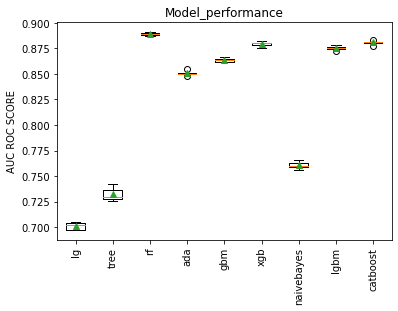

In [61]:
plt.boxplot(result, labels=names, showmeans=True)
plt.xticks(rotation = 90)
plt.ylabel('AUC ROC SCORE')
plt.title('Model_performance')
plt.show()

In [62]:
## Lets start with XGBoost

xgb = XGBClassifier()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) ## 0.7777208151927505 score analytic 

pred_xgb = []
for train_index, test_index in kfold.split(X,y):
    xtrain = X.iloc[train_index]
    ytrain = y.iloc[train_index]
    pred_xgb.append(xgb.fit(xtrain, ytrain).predict_proba(newtest))

In [63]:
##  Generate the predicted values
submission['Outcome'] = pd.DataFrame(np.array(pred_xgb)[0])[1]

In [64]:
submission.to_csv('XGBModel_health.csv',index=False)

In [65]:
### LGBMClassifier

lgbm = LGBMClassifier()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #0.7777208151927505

pred_lgbm = []
for train_index, test_index in kfold.split(X,y):
    xtrain = X.iloc[train_index]
    ytrain = y.iloc[train_index]
    pred_lgbm.append(lgbm.fit(xtrain, ytrain).predict_proba(newtest))

In [66]:
submission['Outcome'] = pd.DataFrame(np.array(pred_lgbm)[0])[1]

In [67]:
submission.to_csv('LGBMModel_health.csv',index=False)

In [68]:
cd

C:\Users\HP


In [69]:
## catboost Classifier
cboost = CatBoostClassifier()
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pred_cboost = []
for train_index, test_index in kfold.split(X,y):
    xtrain = X.iloc[train_index]
    ytrain = y.iloc[train_index]
    pred_cboost.append(cboost.fit(xtrain, ytrain).predict_proba(newtest))

submission['Outcome'] = pd.DataFrame(np.array(pred_lgbm)[0])[1]

submission.to_csv('CatboostModel_health.csv',index=False)

Learning rate set to 0.059277
0:	learn: 0.6561714	total: 170ms	remaining: 2m 49s
1:	learn: 0.6231708	total: 190ms	remaining: 1m 34s
2:	learn: 0.5945105	total: 203ms	remaining: 1m 7s
3:	learn: 0.5709654	total: 222ms	remaining: 55.2s
4:	learn: 0.5505144	total: 242ms	remaining: 48.1s
5:	learn: 0.5342755	total: 260ms	remaining: 43.1s
6:	learn: 0.5195151	total: 279ms	remaining: 39.6s
7:	learn: 0.5052490	total: 296ms	remaining: 36.7s
8:	learn: 0.4939886	total: 309ms	remaining: 34s
9:	learn: 0.4847838	total: 321ms	remaining: 31.8s
10:	learn: 0.4764202	total: 332ms	remaining: 29.9s
11:	learn: 0.4687268	total: 343ms	remaining: 28.3s
12:	learn: 0.4625256	total: 353ms	remaining: 26.8s
13:	learn: 0.4567362	total: 364ms	remaining: 25.6s
14:	learn: 0.4506314	total: 375ms	remaining: 24.6s
15:	learn: 0.4458441	total: 387ms	remaining: 23.8s
16:	learn: 0.4418192	total: 399ms	remaining: 23.1s
17:	learn: 0.4384055	total: 409ms	remaining: 22.3s
18:	learn: 0.4351618	total: 419ms	remaining: 21.7s
19:	learn: 

169:	learn: 0.3853017	total: 2.13s	remaining: 10.4s
170:	learn: 0.3851966	total: 2.15s	remaining: 10.4s
171:	learn: 0.3850795	total: 2.16s	remaining: 10.4s
172:	learn: 0.3849494	total: 2.17s	remaining: 10.4s
173:	learn: 0.3848280	total: 2.18s	remaining: 10.4s
174:	learn: 0.3847428	total: 2.19s	remaining: 10.3s
175:	learn: 0.3845956	total: 2.2s	remaining: 10.3s
176:	learn: 0.3844971	total: 2.22s	remaining: 10.3s
177:	learn: 0.3843667	total: 2.23s	remaining: 10.3s
178:	learn: 0.3842847	total: 2.24s	remaining: 10.3s
179:	learn: 0.3841723	total: 2.25s	remaining: 10.3s
180:	learn: 0.3840502	total: 2.26s	remaining: 10.2s
181:	learn: 0.3839719	total: 2.27s	remaining: 10.2s
182:	learn: 0.3837740	total: 2.29s	remaining: 10.2s
183:	learn: 0.3836852	total: 2.3s	remaining: 10.2s
184:	learn: 0.3835801	total: 2.31s	remaining: 10.2s
185:	learn: 0.3834480	total: 2.32s	remaining: 10.1s
186:	learn: 0.3833642	total: 2.33s	remaining: 10.1s
187:	learn: 0.3832822	total: 2.34s	remaining: 10.1s
188:	learn: 0.

343:	learn: 0.3669861	total: 4.13s	remaining: 7.87s
344:	learn: 0.3668762	total: 4.14s	remaining: 7.86s
345:	learn: 0.3667471	total: 4.15s	remaining: 7.85s
346:	learn: 0.3666484	total: 4.16s	remaining: 7.83s
347:	learn: 0.3665631	total: 4.17s	remaining: 7.82s
348:	learn: 0.3664341	total: 4.18s	remaining: 7.8s
349:	learn: 0.3663317	total: 4.19s	remaining: 7.79s
350:	learn: 0.3662615	total: 4.2s	remaining: 7.77s
351:	learn: 0.3661700	total: 4.22s	remaining: 7.76s
352:	learn: 0.3660794	total: 4.23s	remaining: 7.75s
353:	learn: 0.3659965	total: 4.24s	remaining: 7.73s
354:	learn: 0.3659441	total: 4.25s	remaining: 7.72s
355:	learn: 0.3658340	total: 4.26s	remaining: 7.7s
356:	learn: 0.3657978	total: 4.27s	remaining: 7.69s
357:	learn: 0.3657406	total: 4.28s	remaining: 7.67s
358:	learn: 0.3656263	total: 4.29s	remaining: 7.66s
359:	learn: 0.3655233	total: 4.3s	remaining: 7.64s
360:	learn: 0.3654541	total: 4.31s	remaining: 7.63s
361:	learn: 0.3653519	total: 4.32s	remaining: 7.62s
362:	learn: 0.36

510:	learn: 0.3539037	total: 5.9s	remaining: 5.64s
511:	learn: 0.3538687	total: 5.91s	remaining: 5.63s
512:	learn: 0.3538186	total: 5.92s	remaining: 5.62s
513:	learn: 0.3537521	total: 5.93s	remaining: 5.6s
514:	learn: 0.3537019	total: 5.94s	remaining: 5.59s
515:	learn: 0.3536667	total: 5.95s	remaining: 5.58s
516:	learn: 0.3536300	total: 5.96s	remaining: 5.56s
517:	learn: 0.3535534	total: 5.96s	remaining: 5.55s
518:	learn: 0.3534686	total: 5.97s	remaining: 5.54s
519:	learn: 0.3534250	total: 5.99s	remaining: 5.53s
520:	learn: 0.3533526	total: 6s	remaining: 5.51s
521:	learn: 0.3533053	total: 6s	remaining: 5.5s
522:	learn: 0.3532245	total: 6.01s	remaining: 5.49s
523:	learn: 0.3531600	total: 6.03s	remaining: 5.47s
524:	learn: 0.3530439	total: 6.04s	remaining: 5.46s
525:	learn: 0.3529981	total: 6.04s	remaining: 5.45s
526:	learn: 0.3529779	total: 6.05s	remaining: 5.43s
527:	learn: 0.3529392	total: 6.06s	remaining: 5.42s
528:	learn: 0.3528456	total: 6.07s	remaining: 5.41s
529:	learn: 0.3528059

675:	learn: 0.3431265	total: 7.69s	remaining: 3.68s
676:	learn: 0.3430630	total: 7.7s	remaining: 3.67s
677:	learn: 0.3430003	total: 7.71s	remaining: 3.66s
678:	learn: 0.3429534	total: 7.72s	remaining: 3.65s
679:	learn: 0.3429084	total: 7.73s	remaining: 3.64s
680:	learn: 0.3428371	total: 7.74s	remaining: 3.63s
681:	learn: 0.3427664	total: 7.75s	remaining: 3.62s
682:	learn: 0.3427170	total: 7.76s	remaining: 3.6s
683:	learn: 0.3426735	total: 7.78s	remaining: 3.59s
684:	learn: 0.3425999	total: 7.79s	remaining: 3.58s
685:	learn: 0.3425240	total: 7.8s	remaining: 3.57s
686:	learn: 0.3424863	total: 7.81s	remaining: 3.56s
687:	learn: 0.3424583	total: 7.82s	remaining: 3.54s
688:	learn: 0.3424045	total: 7.83s	remaining: 3.53s
689:	learn: 0.3423687	total: 7.84s	remaining: 3.52s
690:	learn: 0.3423069	total: 7.85s	remaining: 3.51s
691:	learn: 0.3422439	total: 7.86s	remaining: 3.5s
692:	learn: 0.3421772	total: 7.87s	remaining: 3.49s
693:	learn: 0.3421067	total: 7.88s	remaining: 3.48s
694:	learn: 0.34

834:	learn: 0.3337447	total: 9.49s	remaining: 1.88s
835:	learn: 0.3337053	total: 9.51s	remaining: 1.86s
836:	learn: 0.3336284	total: 9.52s	remaining: 1.85s
837:	learn: 0.3335705	total: 9.54s	remaining: 1.84s
838:	learn: 0.3335203	total: 9.55s	remaining: 1.83s
839:	learn: 0.3334557	total: 9.56s	remaining: 1.82s
840:	learn: 0.3333977	total: 9.58s	remaining: 1.81s
841:	learn: 0.3333437	total: 9.6s	remaining: 1.8s
842:	learn: 0.3333124	total: 9.61s	remaining: 1.79s
843:	learn: 0.3332495	total: 9.62s	remaining: 1.78s
844:	learn: 0.3331844	total: 9.64s	remaining: 1.77s
845:	learn: 0.3330975	total: 9.65s	remaining: 1.76s
846:	learn: 0.3330401	total: 9.67s	remaining: 1.75s
847:	learn: 0.3329845	total: 9.68s	remaining: 1.74s
848:	learn: 0.3329185	total: 9.7s	remaining: 1.72s
849:	learn: 0.3328849	total: 9.71s	remaining: 1.71s
850:	learn: 0.3328312	total: 9.72s	remaining: 1.7s
851:	learn: 0.3327915	total: 9.74s	remaining: 1.69s
852:	learn: 0.3327286	total: 9.76s	remaining: 1.68s
853:	learn: 0.33

Learning rate set to 0.059277
0:	learn: 0.6561297	total: 13.3ms	remaining: 13.3s
1:	learn: 0.6228840	total: 28.3ms	remaining: 14.1s
2:	learn: 0.5943537	total: 41ms	remaining: 13.6s
3:	learn: 0.5719479	total: 52.5ms	remaining: 13.1s
4:	learn: 0.5502894	total: 65.4ms	remaining: 13s
5:	learn: 0.5316815	total: 76.2ms	remaining: 12.6s
6:	learn: 0.5171287	total: 87.1ms	remaining: 12.4s
7:	learn: 0.5027633	total: 97.4ms	remaining: 12.1s
8:	learn: 0.4914664	total: 108ms	remaining: 11.9s
9:	learn: 0.4824540	total: 118ms	remaining: 11.7s
10:	learn: 0.4740459	total: 129ms	remaining: 11.6s
11:	learn: 0.4669546	total: 139ms	remaining: 11.4s
12:	learn: 0.4605974	total: 149ms	remaining: 11.3s
13:	learn: 0.4549932	total: 160ms	remaining: 11.3s
14:	learn: 0.4502834	total: 171ms	remaining: 11.2s
15:	learn: 0.4458260	total: 181ms	remaining: 11.1s
16:	learn: 0.4417898	total: 192ms	remaining: 11.1s
17:	learn: 0.4382655	total: 203ms	remaining: 11.1s
18:	learn: 0.4354836	total: 213ms	remaining: 11s
19:	learn

161:	learn: 0.3870690	total: 1.74s	remaining: 8.99s
162:	learn: 0.3869548	total: 1.75s	remaining: 8.98s
163:	learn: 0.3868450	total: 1.76s	remaining: 8.96s
164:	learn: 0.3866649	total: 1.77s	remaining: 8.95s
165:	learn: 0.3865734	total: 1.78s	remaining: 8.94s
166:	learn: 0.3864435	total: 1.79s	remaining: 8.93s
167:	learn: 0.3862824	total: 1.8s	remaining: 8.91s
168:	learn: 0.3861305	total: 1.81s	remaining: 8.9s
169:	learn: 0.3860667	total: 1.82s	remaining: 8.89s
170:	learn: 0.3859497	total: 1.83s	remaining: 8.87s
171:	learn: 0.3858806	total: 1.84s	remaining: 8.86s
172:	learn: 0.3858089	total: 1.85s	remaining: 8.85s
173:	learn: 0.3856241	total: 1.86s	remaining: 8.84s
174:	learn: 0.3854587	total: 1.87s	remaining: 8.83s
175:	learn: 0.3853689	total: 1.88s	remaining: 8.81s
176:	learn: 0.3852832	total: 1.89s	remaining: 8.8s
177:	learn: 0.3851631	total: 1.9s	remaining: 8.79s
178:	learn: 0.3850717	total: 1.91s	remaining: 8.77s
179:	learn: 0.3850196	total: 1.92s	remaining: 8.76s
180:	learn: 0.38

322:	learn: 0.3691835	total: 3.45s	remaining: 7.24s
323:	learn: 0.3690944	total: 3.46s	remaining: 7.23s
324:	learn: 0.3689929	total: 3.48s	remaining: 7.22s
325:	learn: 0.3688767	total: 3.49s	remaining: 7.21s
326:	learn: 0.3688474	total: 3.5s	remaining: 7.2s
327:	learn: 0.3687412	total: 3.51s	remaining: 7.18s
328:	learn: 0.3686833	total: 3.52s	remaining: 7.17s
329:	learn: 0.3685648	total: 3.53s	remaining: 7.16s
330:	learn: 0.3684580	total: 3.54s	remaining: 7.15s
331:	learn: 0.3683450	total: 3.55s	remaining: 7.13s
332:	learn: 0.3682592	total: 3.56s	remaining: 7.12s
333:	learn: 0.3682008	total: 3.56s	remaining: 7.11s
334:	learn: 0.3680790	total: 3.58s	remaining: 7.1s
335:	learn: 0.3679758	total: 3.58s	remaining: 7.08s
336:	learn: 0.3678488	total: 3.6s	remaining: 7.07s
337:	learn: 0.3677599	total: 3.61s	remaining: 7.06s
338:	learn: 0.3676713	total: 3.62s	remaining: 7.05s
339:	learn: 0.3675760	total: 3.63s	remaining: 7.04s
340:	learn: 0.3674390	total: 3.64s	remaining: 7.03s
341:	learn: 0.36

493:	learn: 0.3554809	total: 5.39s	remaining: 5.52s
494:	learn: 0.3554197	total: 5.41s	remaining: 5.51s
495:	learn: 0.3553471	total: 5.42s	remaining: 5.51s
496:	learn: 0.3552543	total: 5.43s	remaining: 5.5s
497:	learn: 0.3551646	total: 5.44s	remaining: 5.49s
498:	learn: 0.3550882	total: 5.45s	remaining: 5.47s
499:	learn: 0.3550064	total: 5.46s	remaining: 5.46s
500:	learn: 0.3549358	total: 5.47s	remaining: 5.45s
501:	learn: 0.3548603	total: 5.49s	remaining: 5.44s
502:	learn: 0.3547664	total: 5.5s	remaining: 5.43s
503:	learn: 0.3547071	total: 5.51s	remaining: 5.42s
504:	learn: 0.3546024	total: 5.53s	remaining: 5.42s
505:	learn: 0.3545087	total: 5.54s	remaining: 5.41s
506:	learn: 0.3544240	total: 5.56s	remaining: 5.41s
507:	learn: 0.3543403	total: 5.57s	remaining: 5.4s
508:	learn: 0.3542693	total: 5.59s	remaining: 5.39s
509:	learn: 0.3541820	total: 5.6s	remaining: 5.38s
510:	learn: 0.3540952	total: 5.61s	remaining: 5.37s
511:	learn: 0.3540021	total: 5.63s	remaining: 5.36s
512:	learn: 0.35

662:	learn: 0.3438930	total: 7.38s	remaining: 3.75s
663:	learn: 0.3438086	total: 7.39s	remaining: 3.74s
664:	learn: 0.3437656	total: 7.4s	remaining: 3.73s
665:	learn: 0.3436800	total: 7.41s	remaining: 3.72s
666:	learn: 0.3435876	total: 7.42s	remaining: 3.71s
667:	learn: 0.3435315	total: 7.43s	remaining: 3.69s
668:	learn: 0.3434586	total: 7.44s	remaining: 3.68s
669:	learn: 0.3434250	total: 7.45s	remaining: 3.67s
670:	learn: 0.3433671	total: 7.46s	remaining: 3.66s
671:	learn: 0.3433549	total: 7.47s	remaining: 3.65s
672:	learn: 0.3433177	total: 7.48s	remaining: 3.64s
673:	learn: 0.3432158	total: 7.5s	remaining: 3.63s
674:	learn: 0.3431304	total: 7.51s	remaining: 3.61s
675:	learn: 0.3430719	total: 7.52s	remaining: 3.6s
676:	learn: 0.3430191	total: 7.53s	remaining: 3.59s
677:	learn: 0.3429339	total: 7.54s	remaining: 3.58s
678:	learn: 0.3428783	total: 7.55s	remaining: 3.57s
679:	learn: 0.3428234	total: 7.56s	remaining: 3.56s
680:	learn: 0.3427696	total: 7.57s	remaining: 3.55s
681:	learn: 0.3

826:	learn: 0.3342304	total: 9.16s	remaining: 1.92s
827:	learn: 0.3341754	total: 9.17s	remaining: 1.9s
828:	learn: 0.3341221	total: 9.18s	remaining: 1.89s
829:	learn: 0.3340621	total: 9.19s	remaining: 1.88s
830:	learn: 0.3340055	total: 9.2s	remaining: 1.87s
831:	learn: 0.3339330	total: 9.21s	remaining: 1.86s
832:	learn: 0.3339090	total: 9.22s	remaining: 1.85s
833:	learn: 0.3338584	total: 9.23s	remaining: 1.84s
834:	learn: 0.3338319	total: 9.24s	remaining: 1.83s
835:	learn: 0.3337758	total: 9.25s	remaining: 1.81s
836:	learn: 0.3337298	total: 9.26s	remaining: 1.8s
837:	learn: 0.3336620	total: 9.28s	remaining: 1.79s
838:	learn: 0.3335854	total: 9.3s	remaining: 1.78s
839:	learn: 0.3335268	total: 9.31s	remaining: 1.77s
840:	learn: 0.3334668	total: 9.32s	remaining: 1.76s
841:	learn: 0.3334148	total: 9.34s	remaining: 1.75s
842:	learn: 0.3333425	total: 9.35s	remaining: 1.74s
843:	learn: 0.3332969	total: 9.36s	remaining: 1.73s
844:	learn: 0.3332323	total: 9.37s	remaining: 1.72s
845:	learn: 0.33

989:	learn: 0.3254282	total: 10.9s	remaining: 110ms
990:	learn: 0.3253480	total: 10.9s	remaining: 98.9ms
991:	learn: 0.3252788	total: 10.9s	remaining: 87.9ms
992:	learn: 0.3252272	total: 10.9s	remaining: 76.9ms
993:	learn: 0.3251595	total: 10.9s	remaining: 65.9ms
994:	learn: 0.3250842	total: 10.9s	remaining: 54.9ms
995:	learn: 0.3250366	total: 10.9s	remaining: 43.9ms
996:	learn: 0.3249823	total: 10.9s	remaining: 32.9ms
997:	learn: 0.3249171	total: 11s	remaining: 22ms
998:	learn: 0.3248689	total: 11s	remaining: 11ms
999:	learn: 0.3248264	total: 11s	remaining: 0us
Learning rate set to 0.059277
0:	learn: 0.6567329	total: 22.8ms	remaining: 22.7s
1:	learn: 0.6232131	total: 44ms	remaining: 22s
2:	learn: 0.5956078	total: 64.6ms	remaining: 21.5s
3:	learn: 0.5721714	total: 80.4ms	remaining: 20s
4:	learn: 0.5515532	total: 93.7ms	remaining: 18.7s
5:	learn: 0.5346394	total: 108ms	remaining: 17.9s
6:	learn: 0.5184143	total: 125ms	remaining: 17.8s
7:	learn: 0.5050164	total: 142ms	remaining: 17.6s
8:

154:	learn: 0.3886366	total: 1.79s	remaining: 9.78s
155:	learn: 0.3885579	total: 1.8s	remaining: 9.76s
156:	learn: 0.3884325	total: 1.81s	remaining: 9.74s
157:	learn: 0.3881422	total: 1.83s	remaining: 9.74s
158:	learn: 0.3879919	total: 1.84s	remaining: 9.72s
159:	learn: 0.3879160	total: 1.85s	remaining: 9.7s
160:	learn: 0.3878223	total: 1.86s	remaining: 9.69s
161:	learn: 0.3877024	total: 1.87s	remaining: 9.67s
162:	learn: 0.3875729	total: 1.88s	remaining: 9.67s
163:	learn: 0.3874850	total: 1.9s	remaining: 9.66s
164:	learn: 0.3873903	total: 1.91s	remaining: 9.64s
165:	learn: 0.3873213	total: 1.92s	remaining: 9.63s
166:	learn: 0.3871602	total: 1.93s	remaining: 9.62s
167:	learn: 0.3870419	total: 1.94s	remaining: 9.61s
168:	learn: 0.3869432	total: 1.95s	remaining: 9.61s
169:	learn: 0.3868267	total: 1.97s	remaining: 9.61s
170:	learn: 0.3867450	total: 1.98s	remaining: 9.61s
171:	learn: 0.3866183	total: 2s	remaining: 9.62s
172:	learn: 0.3865254	total: 2.01s	remaining: 9.62s
173:	learn: 0.3864

325:	learn: 0.3705940	total: 4.01s	remaining: 8.28s
326:	learn: 0.3705311	total: 4.02s	remaining: 8.27s
327:	learn: 0.3704605	total: 4.03s	remaining: 8.26s
328:	learn: 0.3703690	total: 4.04s	remaining: 8.24s
329:	learn: 0.3702300	total: 4.06s	remaining: 8.24s
330:	learn: 0.3701225	total: 4.07s	remaining: 8.22s
331:	learn: 0.3700112	total: 4.08s	remaining: 8.21s
332:	learn: 0.3699273	total: 4.09s	remaining: 8.2s
333:	learn: 0.3698463	total: 4.11s	remaining: 8.19s
334:	learn: 0.3697911	total: 4.12s	remaining: 8.18s
335:	learn: 0.3697196	total: 4.13s	remaining: 8.16s
336:	learn: 0.3696560	total: 4.14s	remaining: 8.15s
337:	learn: 0.3695771	total: 4.16s	remaining: 8.14s
338:	learn: 0.3694892	total: 4.17s	remaining: 8.13s
339:	learn: 0.3693908	total: 4.18s	remaining: 8.12s
340:	learn: 0.3693199	total: 4.2s	remaining: 8.11s
341:	learn: 0.3692359	total: 4.21s	remaining: 8.09s
342:	learn: 0.3691628	total: 4.22s	remaining: 8.08s
343:	learn: 0.3691397	total: 4.23s	remaining: 8.07s
344:	learn: 0.

495:	learn: 0.3572961	total: 6.15s	remaining: 6.25s
496:	learn: 0.3572255	total: 6.17s	remaining: 6.25s
497:	learn: 0.3571396	total: 6.19s	remaining: 6.24s
498:	learn: 0.3570509	total: 6.21s	remaining: 6.24s
499:	learn: 0.3569843	total: 6.23s	remaining: 6.23s
500:	learn: 0.3569054	total: 6.25s	remaining: 6.22s
501:	learn: 0.3568132	total: 6.26s	remaining: 6.21s
502:	learn: 0.3567658	total: 6.27s	remaining: 6.2s
503:	learn: 0.3566845	total: 6.28s	remaining: 6.18s
504:	learn: 0.3566242	total: 6.29s	remaining: 6.17s
505:	learn: 0.3565660	total: 6.3s	remaining: 6.15s
506:	learn: 0.3564922	total: 6.31s	remaining: 6.14s
507:	learn: 0.3564053	total: 6.32s	remaining: 6.13s
508:	learn: 0.3563671	total: 6.34s	remaining: 6.11s
509:	learn: 0.3563034	total: 6.35s	remaining: 6.1s
510:	learn: 0.3562227	total: 6.36s	remaining: 6.09s
511:	learn: 0.3561191	total: 6.37s	remaining: 6.07s
512:	learn: 0.3560595	total: 6.38s	remaining: 6.06s
513:	learn: 0.3560280	total: 6.39s	remaining: 6.04s
514:	learn: 0.3

665:	learn: 0.3458552	total: 8.36s	remaining: 4.19s
666:	learn: 0.3457709	total: 8.38s	remaining: 4.18s
667:	learn: 0.3456812	total: 8.39s	remaining: 4.17s
668:	learn: 0.3456114	total: 8.4s	remaining: 4.16s
669:	learn: 0.3455452	total: 8.41s	remaining: 4.14s
670:	learn: 0.3454782	total: 8.43s	remaining: 4.13s
671:	learn: 0.3454160	total: 8.44s	remaining: 4.12s
672:	learn: 0.3453424	total: 8.45s	remaining: 4.11s
673:	learn: 0.3452995	total: 8.46s	remaining: 4.09s
674:	learn: 0.3452481	total: 8.47s	remaining: 4.08s
675:	learn: 0.3452073	total: 8.49s	remaining: 4.07s
676:	learn: 0.3451319	total: 8.5s	remaining: 4.05s
677:	learn: 0.3450838	total: 8.51s	remaining: 4.04s
678:	learn: 0.3450196	total: 8.53s	remaining: 4.03s
679:	learn: 0.3449805	total: 8.54s	remaining: 4.02s
680:	learn: 0.3449103	total: 8.55s	remaining: 4.01s
681:	learn: 0.3448579	total: 8.56s	remaining: 3.99s
682:	learn: 0.3447970	total: 8.58s	remaining: 3.98s
683:	learn: 0.3447246	total: 8.59s	remaining: 3.97s
684:	learn: 0.

835:	learn: 0.3350578	total: 10.8s	remaining: 2.11s
836:	learn: 0.3350152	total: 10.8s	remaining: 2.1s
837:	learn: 0.3349430	total: 10.8s	remaining: 2.08s
838:	learn: 0.3348800	total: 10.8s	remaining: 2.07s
839:	learn: 0.3348161	total: 10.8s	remaining: 2.06s
840:	learn: 0.3347267	total: 10.8s	remaining: 2.05s
841:	learn: 0.3346561	total: 10.8s	remaining: 2.03s
842:	learn: 0.3346308	total: 10.8s	remaining: 2.02s
843:	learn: 0.3345643	total: 10.9s	remaining: 2.01s
844:	learn: 0.3344833	total: 10.9s	remaining: 1.99s
845:	learn: 0.3344370	total: 10.9s	remaining: 1.98s
846:	learn: 0.3343665	total: 10.9s	remaining: 1.97s
847:	learn: 0.3343317	total: 10.9s	remaining: 1.95s
848:	learn: 0.3342477	total: 10.9s	remaining: 1.94s
849:	learn: 0.3341825	total: 10.9s	remaining: 1.93s
850:	learn: 0.3341291	total: 11s	remaining: 1.92s
851:	learn: 0.3341048	total: 11s	remaining: 1.91s
852:	learn: 0.3340718	total: 11s	remaining: 1.89s
853:	learn: 0.3339906	total: 11s	remaining: 1.88s
854:	learn: 0.3339583

999:	learn: 0.3264266	total: 13.2s	remaining: 0us
Learning rate set to 0.059278
0:	learn: 0.6563640	total: 25.7ms	remaining: 25.6s
1:	learn: 0.6233741	total: 47.3ms	remaining: 23.6s
2:	learn: 0.5948007	total: 69.5ms	remaining: 23.1s
3:	learn: 0.5714275	total: 88.4ms	remaining: 22s
4:	learn: 0.5510496	total: 104ms	remaining: 20.8s
5:	learn: 0.5337036	total: 121ms	remaining: 20s
6:	learn: 0.5189449	total: 134ms	remaining: 19s
7:	learn: 0.5063119	total: 148ms	remaining: 18.3s
8:	learn: 0.4944741	total: 161ms	remaining: 17.8s
9:	learn: 0.4842378	total: 174ms	remaining: 17.2s
10:	learn: 0.4747616	total: 188ms	remaining: 16.9s
11:	learn: 0.4679983	total: 200ms	remaining: 16.5s
12:	learn: 0.4617819	total: 214ms	remaining: 16.2s
13:	learn: 0.4561531	total: 226ms	remaining: 15.9s
14:	learn: 0.4506486	total: 239ms	remaining: 15.7s
15:	learn: 0.4463817	total: 253ms	remaining: 15.6s
16:	learn: 0.4423852	total: 267ms	remaining: 15.4s
17:	learn: 0.4384129	total: 281ms	remaining: 15.4s
18:	learn: 0.4

164:	learn: 0.3870519	total: 2.4s	remaining: 12.1s
165:	learn: 0.3869563	total: 2.41s	remaining: 12.1s
166:	learn: 0.3868442	total: 2.42s	remaining: 12.1s
167:	learn: 0.3864808	total: 2.44s	remaining: 12.1s
168:	learn: 0.3863805	total: 2.45s	remaining: 12.1s
169:	learn: 0.3862267	total: 2.47s	remaining: 12.1s
170:	learn: 0.3860667	total: 2.48s	remaining: 12s
171:	learn: 0.3859648	total: 2.5s	remaining: 12s
172:	learn: 0.3859025	total: 2.52s	remaining: 12s
173:	learn: 0.3857311	total: 2.53s	remaining: 12s
174:	learn: 0.3856301	total: 2.54s	remaining: 12s
175:	learn: 0.3855032	total: 2.56s	remaining: 12s
176:	learn: 0.3853865	total: 2.57s	remaining: 12s
177:	learn: 0.3852397	total: 2.59s	remaining: 11.9s
178:	learn: 0.3851485	total: 2.6s	remaining: 11.9s
179:	learn: 0.3850233	total: 2.61s	remaining: 11.9s
180:	learn: 0.3848501	total: 2.63s	remaining: 11.9s
181:	learn: 0.3847148	total: 2.64s	remaining: 11.9s
182:	learn: 0.3845811	total: 2.66s	remaining: 11.9s
183:	learn: 0.3844515	total: 

331:	learn: 0.3684108	total: 4.8s	remaining: 9.67s
332:	learn: 0.3683200	total: 4.82s	remaining: 9.65s
333:	learn: 0.3682424	total: 4.83s	remaining: 9.64s
334:	learn: 0.3681795	total: 4.85s	remaining: 9.62s
335:	learn: 0.3680803	total: 4.86s	remaining: 9.61s
336:	learn: 0.3680273	total: 4.88s	remaining: 9.59s
337:	learn: 0.3679370	total: 4.89s	remaining: 9.58s
338:	learn: 0.3678581	total: 4.91s	remaining: 9.56s
339:	learn: 0.3677503	total: 4.92s	remaining: 9.55s
340:	learn: 0.3676535	total: 4.93s	remaining: 9.54s
341:	learn: 0.3675940	total: 4.95s	remaining: 9.52s
342:	learn: 0.3674738	total: 4.96s	remaining: 9.51s
343:	learn: 0.3673532	total: 4.98s	remaining: 9.49s
344:	learn: 0.3672749	total: 4.99s	remaining: 9.48s
345:	learn: 0.3671739	total: 5.01s	remaining: 9.47s
346:	learn: 0.3670771	total: 5.02s	remaining: 9.45s
347:	learn: 0.3670103	total: 5.03s	remaining: 9.43s
348:	learn: 0.3669118	total: 5.05s	remaining: 9.42s
349:	learn: 0.3667934	total: 5.06s	remaining: 9.4s
350:	learn: 0.

497:	learn: 0.3549628	total: 7.4s	remaining: 7.46s
498:	learn: 0.3548898	total: 7.42s	remaining: 7.45s
499:	learn: 0.3548045	total: 7.43s	remaining: 7.43s
500:	learn: 0.3547078	total: 7.45s	remaining: 7.42s
501:	learn: 0.3546339	total: 7.47s	remaining: 7.41s
502:	learn: 0.3545466	total: 7.49s	remaining: 7.4s
503:	learn: 0.3545002	total: 7.51s	remaining: 7.39s
504:	learn: 0.3543758	total: 7.53s	remaining: 7.38s
505:	learn: 0.3543318	total: 7.55s	remaining: 7.37s
506:	learn: 0.3542448	total: 7.56s	remaining: 7.35s
507:	learn: 0.3541381	total: 7.58s	remaining: 7.34s
508:	learn: 0.3540556	total: 7.59s	remaining: 7.33s
509:	learn: 0.3539850	total: 7.61s	remaining: 7.31s
510:	learn: 0.3538700	total: 7.63s	remaining: 7.3s
511:	learn: 0.3537683	total: 7.65s	remaining: 7.29s
512:	learn: 0.3536186	total: 7.67s	remaining: 7.28s
513:	learn: 0.3535246	total: 7.69s	remaining: 7.27s
514:	learn: 0.3534844	total: 7.71s	remaining: 7.26s
515:	learn: 0.3533920	total: 7.72s	remaining: 7.25s
516:	learn: 0.3

665:	learn: 0.3431735	total: 9.99s	remaining: 5.01s
666:	learn: 0.3431176	total: 10s	remaining: 5s
667:	learn: 0.3430901	total: 10s	remaining: 4.98s
668:	learn: 0.3430180	total: 10s	remaining: 4.97s
669:	learn: 0.3429225	total: 10.1s	remaining: 4.96s
670:	learn: 0.3428430	total: 10.1s	remaining: 4.95s
671:	learn: 0.3427589	total: 10.1s	remaining: 4.94s
672:	learn: 0.3427034	total: 10.1s	remaining: 4.92s
673:	learn: 0.3426319	total: 10.2s	remaining: 4.91s
674:	learn: 0.3425782	total: 10.2s	remaining: 4.9s
675:	learn: 0.3424860	total: 10.2s	remaining: 4.88s
676:	learn: 0.3424293	total: 10.2s	remaining: 4.87s
677:	learn: 0.3423695	total: 10.2s	remaining: 4.85s
678:	learn: 0.3423436	total: 10.2s	remaining: 4.83s
679:	learn: 0.3422762	total: 10.2s	remaining: 4.82s
680:	learn: 0.3422131	total: 10.3s	remaining: 4.8s
681:	learn: 0.3421406	total: 10.3s	remaining: 4.79s
682:	learn: 0.3420901	total: 10.3s	remaining: 4.77s
683:	learn: 0.3420336	total: 10.3s	remaining: 4.75s
684:	learn: 0.3419768	t

833:	learn: 0.3326760	total: 12.6s	remaining: 2.5s
834:	learn: 0.3326232	total: 12.6s	remaining: 2.49s
835:	learn: 0.3325658	total: 12.6s	remaining: 2.47s
836:	learn: 0.3324909	total: 12.6s	remaining: 2.46s
837:	learn: 0.3324353	total: 12.6s	remaining: 2.44s
838:	learn: 0.3323788	total: 12.6s	remaining: 2.42s
839:	learn: 0.3323234	total: 12.6s	remaining: 2.41s
840:	learn: 0.3322698	total: 12.7s	remaining: 2.39s
841:	learn: 0.3321998	total: 12.7s	remaining: 2.38s
842:	learn: 0.3321576	total: 12.7s	remaining: 2.36s
843:	learn: 0.3321138	total: 12.7s	remaining: 2.35s
844:	learn: 0.3320607	total: 12.7s	remaining: 2.33s
845:	learn: 0.3320421	total: 12.7s	remaining: 2.31s
846:	learn: 0.3319605	total: 12.7s	remaining: 2.3s
847:	learn: 0.3318736	total: 12.7s	remaining: 2.28s
848:	learn: 0.3318299	total: 12.8s	remaining: 2.27s
849:	learn: 0.3317890	total: 12.8s	remaining: 2.25s
850:	learn: 0.3317413	total: 12.8s	remaining: 2.24s
851:	learn: 0.3316705	total: 12.8s	remaining: 2.22s
852:	learn: 0.

997:	learn: 0.3235551	total: 15.2s	remaining: 30.6ms
998:	learn: 0.3234932	total: 15.3s	remaining: 15.3ms
999:	learn: 0.3234340	total: 15.3s	remaining: 0us
Learning rate set to 0.059278
0:	learn: 0.6562347	total: 24.3ms	remaining: 24.3s
1:	learn: 0.6230225	total: 46.7ms	remaining: 23.3s
2:	learn: 0.5944036	total: 66.6ms	remaining: 22.1s
3:	learn: 0.5707223	total: 87.4ms	remaining: 21.8s
4:	learn: 0.5501725	total: 107ms	remaining: 21.3s
5:	learn: 0.5317614	total: 127ms	remaining: 21s
6:	learn: 0.5157495	total: 144ms	remaining: 20.4s
7:	learn: 0.5020094	total: 159ms	remaining: 19.7s
8:	learn: 0.4911742	total: 172ms	remaining: 18.9s
9:	learn: 0.4816701	total: 185ms	remaining: 18.3s
10:	learn: 0.4728261	total: 197ms	remaining: 17.7s
11:	learn: 0.4650580	total: 208ms	remaining: 17.2s
12:	learn: 0.4588385	total: 219ms	remaining: 16.6s
13:	learn: 0.4535654	total: 231ms	remaining: 16.2s
14:	learn: 0.4485679	total: 242ms	remaining: 15.9s
15:	learn: 0.4444219	total: 252ms	remaining: 15.5s
16:	le

163:	learn: 0.3854627	total: 2.64s	remaining: 13.5s
164:	learn: 0.3853181	total: 2.65s	remaining: 13.4s
165:	learn: 0.3852046	total: 2.67s	remaining: 13.4s
166:	learn: 0.3850949	total: 2.69s	remaining: 13.4s
167:	learn: 0.3849939	total: 2.7s	remaining: 13.4s
168:	learn: 0.3849355	total: 2.72s	remaining: 13.4s
169:	learn: 0.3847923	total: 2.73s	remaining: 13.4s
170:	learn: 0.3846510	total: 2.75s	remaining: 13.3s
171:	learn: 0.3845566	total: 2.77s	remaining: 13.3s
172:	learn: 0.3844463	total: 2.79s	remaining: 13.3s
173:	learn: 0.3843155	total: 2.81s	remaining: 13.3s
174:	learn: 0.3841745	total: 2.85s	remaining: 13.4s
175:	learn: 0.3840755	total: 2.87s	remaining: 13.4s
176:	learn: 0.3839911	total: 2.89s	remaining: 13.5s
177:	learn: 0.3838346	total: 2.91s	remaining: 13.4s
178:	learn: 0.3837255	total: 2.93s	remaining: 13.4s
179:	learn: 0.3836644	total: 2.95s	remaining: 13.4s
180:	learn: 0.3835500	total: 2.97s	remaining: 13.4s
181:	learn: 0.3832635	total: 2.99s	remaining: 13.5s
182:	learn: 0

330:	learn: 0.3671144	total: 5.56s	remaining: 11.2s
331:	learn: 0.3669996	total: 5.58s	remaining: 11.2s
332:	learn: 0.3669269	total: 5.61s	remaining: 11.2s
333:	learn: 0.3668484	total: 5.63s	remaining: 11.2s
334:	learn: 0.3668040	total: 5.66s	remaining: 11.2s
335:	learn: 0.3667101	total: 5.68s	remaining: 11.2s
336:	learn: 0.3665878	total: 5.71s	remaining: 11.2s
337:	learn: 0.3664965	total: 5.73s	remaining: 11.2s
338:	learn: 0.3663894	total: 5.75s	remaining: 11.2s
339:	learn: 0.3663146	total: 5.78s	remaining: 11.2s
340:	learn: 0.3662145	total: 5.8s	remaining: 11.2s
341:	learn: 0.3661364	total: 5.83s	remaining: 11.2s
342:	learn: 0.3660928	total: 5.85s	remaining: 11.2s
343:	learn: 0.3660151	total: 5.87s	remaining: 11.2s
344:	learn: 0.3658910	total: 5.9s	remaining: 11.2s
345:	learn: 0.3658070	total: 5.92s	remaining: 11.2s
346:	learn: 0.3657276	total: 5.95s	remaining: 11.2s
347:	learn: 0.3656526	total: 5.97s	remaining: 11.2s
348:	learn: 0.3655906	total: 6s	remaining: 11.2s
349:	learn: 0.365

500:	learn: 0.3531006	total: 9.12s	remaining: 9.08s
501:	learn: 0.3530267	total: 9.13s	remaining: 9.06s
502:	learn: 0.3529437	total: 9.15s	remaining: 9.04s
503:	learn: 0.3528621	total: 9.16s	remaining: 9.02s
504:	learn: 0.3527832	total: 9.18s	remaining: 9s
505:	learn: 0.3527104	total: 9.19s	remaining: 8.97s
506:	learn: 0.3526277	total: 9.21s	remaining: 8.95s
507:	learn: 0.3525609	total: 9.22s	remaining: 8.93s
508:	learn: 0.3524856	total: 9.23s	remaining: 8.91s
509:	learn: 0.3523959	total: 9.24s	remaining: 8.88s
510:	learn: 0.3523539	total: 9.26s	remaining: 8.86s
511:	learn: 0.3522826	total: 9.27s	remaining: 8.83s
512:	learn: 0.3522145	total: 9.28s	remaining: 8.81s
513:	learn: 0.3521139	total: 9.29s	remaining: 8.79s
514:	learn: 0.3520284	total: 9.31s	remaining: 8.77s
515:	learn: 0.3519540	total: 9.32s	remaining: 8.74s
516:	learn: 0.3519217	total: 9.33s	remaining: 8.72s
517:	learn: 0.3518949	total: 9.35s	remaining: 8.7s
518:	learn: 0.3518107	total: 9.36s	remaining: 8.67s
519:	learn: 0.35

660:	learn: 0.3422688	total: 11.3s	remaining: 5.81s
661:	learn: 0.3421945	total: 11.3s	remaining: 5.79s
662:	learn: 0.3421051	total: 11.4s	remaining: 5.78s
663:	learn: 0.3420167	total: 11.4s	remaining: 5.76s
664:	learn: 0.3419565	total: 11.4s	remaining: 5.74s
665:	learn: 0.3418668	total: 11.4s	remaining: 5.72s
666:	learn: 0.3418113	total: 11.4s	remaining: 5.7s
667:	learn: 0.3417476	total: 11.4s	remaining: 5.68s
668:	learn: 0.3416495	total: 11.5s	remaining: 5.67s
669:	learn: 0.3415973	total: 11.5s	remaining: 5.65s
670:	learn: 0.3415166	total: 11.5s	remaining: 5.63s
671:	learn: 0.3414514	total: 11.5s	remaining: 5.61s
672:	learn: 0.3414002	total: 11.5s	remaining: 5.59s
673:	learn: 0.3413383	total: 11.5s	remaining: 5.58s
674:	learn: 0.3412587	total: 11.5s	remaining: 5.56s
675:	learn: 0.3411869	total: 11.6s	remaining: 5.54s
676:	learn: 0.3411294	total: 11.6s	remaining: 5.52s
677:	learn: 0.3410753	total: 11.6s	remaining: 5.5s
678:	learn: 0.3410189	total: 11.6s	remaining: 5.48s
679:	learn: 0.

827:	learn: 0.3321911	total: 14s	remaining: 2.91s
828:	learn: 0.3321389	total: 14s	remaining: 2.89s
829:	learn: 0.3320877	total: 14s	remaining: 2.87s
830:	learn: 0.3320399	total: 14s	remaining: 2.86s
831:	learn: 0.3319870	total: 14.1s	remaining: 2.84s
832:	learn: 0.3319158	total: 14.1s	remaining: 2.82s
833:	learn: 0.3318641	total: 14.1s	remaining: 2.8s
834:	learn: 0.3317818	total: 14.1s	remaining: 2.79s
835:	learn: 0.3317307	total: 14.1s	remaining: 2.77s
836:	learn: 0.3316865	total: 14.1s	remaining: 2.75s
837:	learn: 0.3316454	total: 14.2s	remaining: 2.74s
838:	learn: 0.3315661	total: 14.2s	remaining: 2.72s
839:	learn: 0.3315067	total: 14.2s	remaining: 2.7s
840:	learn: 0.3314255	total: 14.2s	remaining: 2.69s
841:	learn: 0.3313896	total: 14.2s	remaining: 2.67s
842:	learn: 0.3313353	total: 14.2s	remaining: 2.65s
843:	learn: 0.3312615	total: 14.2s	remaining: 2.63s
844:	learn: 0.3312229	total: 14.3s	remaining: 2.62s
845:	learn: 0.3311280	total: 14.3s	remaining: 2.6s
846:	learn: 0.3310795	t

990:	learn: 0.3232544	total: 16.3s	remaining: 148ms
991:	learn: 0.3232101	total: 16.3s	remaining: 131ms
992:	learn: 0.3231552	total: 16.3s	remaining: 115ms
993:	learn: 0.3231058	total: 16.3s	remaining: 98.6ms
994:	learn: 0.3230400	total: 16.3s	remaining: 82.1ms
995:	learn: 0.3230212	total: 16.4s	remaining: 65.7ms
996:	learn: 0.3229829	total: 16.4s	remaining: 49.2ms
997:	learn: 0.3229445	total: 16.4s	remaining: 32.8ms
998:	learn: 0.3228951	total: 16.4s	remaining: 16.4ms
999:	learn: 0.3228605	total: 16.4s	remaining: 0us


In [70]:
## stacking Classifier

from sklearn.ensemble import StackingClassifier
base=[("xgb",XGBClassifier())]
      
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
      
from  sklearn.ensemble import StackingClassifier
      
stack= StackingClassifier(estimators=base,final_estimator=LGBMClassifier(),cv=cv)


pred_stack=[]
for train_index,test_index in kfold.split(X,y):
    xtrain=X.iloc[train_index]
    ytrain=y.iloc[train_index]
    pred_stack.append(stack.fit(xtrain,ytrain).predict_proba(newtest))
    
submission["Outcome"]=pd.DataFrame(np.array(pred_stack)[0])[1]
submission.to_csv("Stack_HEALTH.csv",index=False)
    